# Exploratory Analysis

I choose the simplest application with the nutriscore : Predict it for non-label aliments. My main question will be about the robustess of my missing data inference. I read about this score [on this official document](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique) (on "sante public france" [website](https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score))

In [2]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import sklearn
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
import seaborn as sns
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

In [3]:
data = pd.read_csv(data_path+"projet2/cleanned_dataframe.csv",  index_col =0)
data_std = pd.read_csv(data_path+"projet2/cleanned_std_dataframe.csv",  index_col =0)

# 1. Nutri-score analysis : 

In [4]:
y = data["nutrition-score-fr_100g"].copy()
y.describe()

count    9976.000000
mean        9.068665
std         8.896937
min       -13.000000
25%         1.000000
50%        10.000000
75%        16.000000
max        37.000000
Name: nutrition-score-fr_100g, dtype: float64

Text(0.5, 1.0, 'nutrition-score')

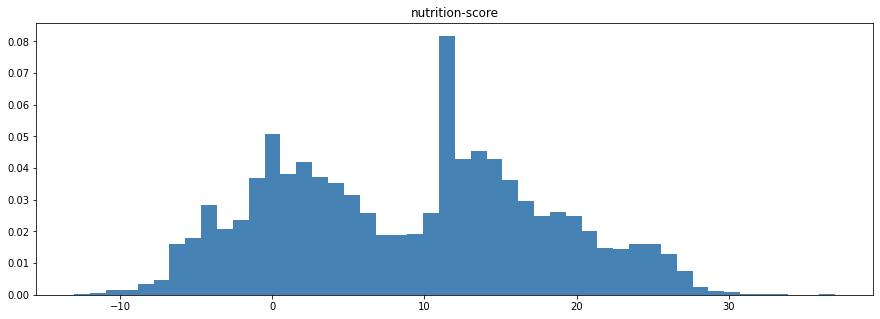

In [5]:
nb_bins = len(np.unique(y.dropna().values))
plt.hist(y, bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("nutrition-score")

This varible as both negative and positive values, but I still look at the Lorenz curve and AUC, after rescaling y with a min-translatation : 

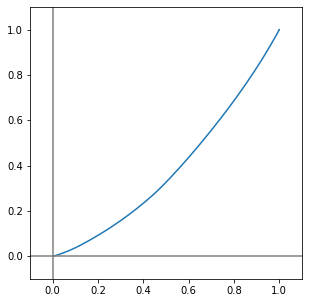

In [7]:
## lorenz curve : 
import numpy as np

n = len(y)
y_rescaled = y - min(y)
lorenz = np.cumsum(np.sort(y_rescaled)) / y_rescaled.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig, ax = plt.subplots()

ax.axis('scaled')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0,0],[-0.1,1.1], color="grey") # y axis 
plt.plot([-0.1,1.1],[0,0], color="grey") # x axis

plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S

The AUC is {{np.round(AUC,2)}}, that means that ... .
Futhermore, the gini indice is {{np.round(gini,2)}}

**write the interpretation + solve affichage variable in markedown**
https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4730366-familiarisez-vous-avec-les-mesures-de-concentration

# 2. Country variable : 

In [ ]:
##################################################

From the [notice form](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique) page 28, ones have how the positive and negative points are attributed : 

In [105]:
ref_scores_neg = pd.DataFrame(np.array([np.arange(0, -11, -1), 
                                  [0, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350],
                                  [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, 10**6],
                                  [0, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45],
                                  [4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, 100],
                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,100],
                                  [0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900],
                                  [90, 180, 270, 360, 450, 540, 630, 720, 810, 900, 1000]
                                ]).T,
                                 columns = ["points", "densite_energetique_min", "densite_energetique_max",
                                           "sugar_min", "sugar_max",
                                           "acides_gras_satures_min", "acides_gras_satures_max",
                                           "sodium_min", "sodium_max"])
ref_scores_neg.loc["unit",:] = ["int","kJ_100g","kJ_100g", "g_100g", "g_100g", 
                                        "g_100g", "g_100g","mg_100g","mg_100g"]

ref_scores_pos = pd.DataFrame(np.array([np.arange(0, 6, 1), 
                                               [0, 40, 60, 100, 100, 80], ## 2 values impossibles
                                               [40, 60, 80, -100,-100, 100],
                                               [0, 0.9, 1.9, 2.8, 3.7, 4.7],
                                               [0.9, 1.9, 2.8, 3.7, 4.7, 100],
                                               [0, 1.6, 3.2, 4.8, 6.4, 8],
                                               [1.6, 3.2, 4.8, 6.4, 8, 100],
                                              ]).T,
                                 columns = ["points", "legumes_min", "legumes_max",
                                           "fibre_min", "fibre_max", "proteine_min", "proteine_max"])
ref_scores_pos.loc["unit",:] = ["int","%","%", "g_100g", "g_100g", "g_100g", "g_100g"]


# 2. Dimension Reduction 
## 2.1 Correlation Matrix :
Let us first of all see if the variable are correlated : 

In [3]:
def plot_corr_heatmap(corr): 
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

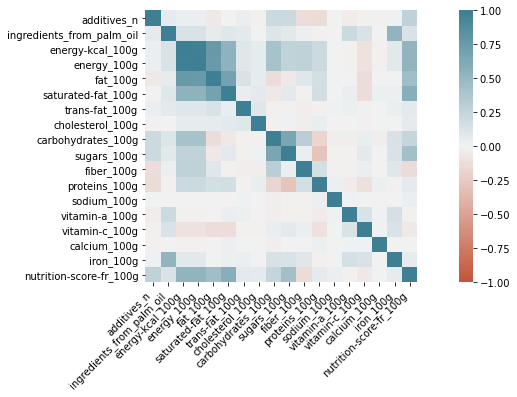

In [4]:
corr = data.corr()
plot_corr_heatmap(corr)

Let's sort the correlation index by the values in the nutrition score : 

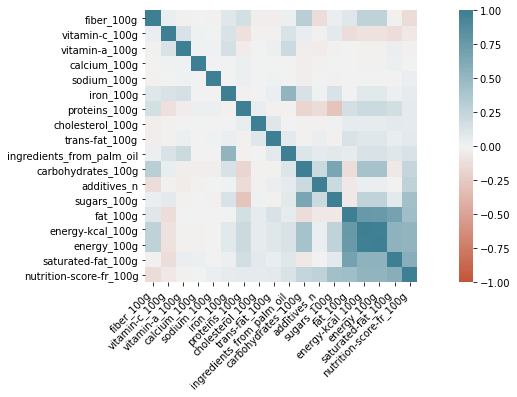

In [5]:
sorted_corr = corr.sort_values(by="nutrition-score-fr_100g", ascending = True)
sorted_corr = sorted_corr.sort_values(by="nutrition-score-fr_100g", axis = 1, ascending = True)
plot_corr_heatmap(sorted_corr)

There seems to be a cluster of correlated variable conserning fat and energy, and the other variables does not seem so correlated. If it's the case, computing a PCA. 
Note that most of this code is an adapation of [the TP code proposed in the OC class](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp). 

In [6]:
from functions import *
from sklearn import decomposition
from sklearn import preprocessing

# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP
X = data.drop("nutrition-score-fr_100g",axis = 1, inplace = False)

# préparation des données pour l'ACP
scores = np.intc(data["nutrition-score-fr_100g"]) # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

Let's see the explained variance each new component brings : 

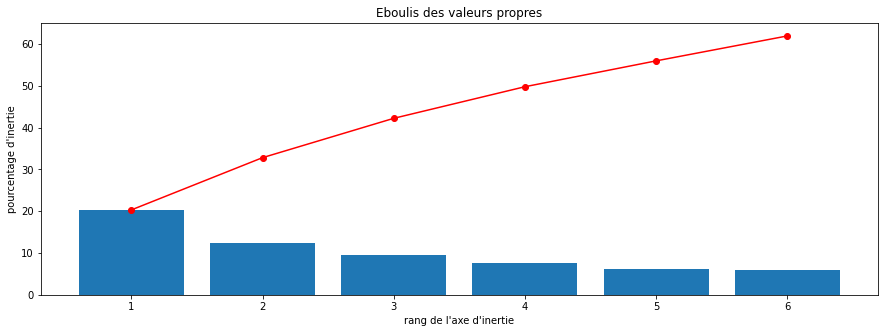

In [7]:
# Eboulis des valeurs propres
display_scree_plot(pca)

The first axe explaines 20% of the variance, and the second 12.5%. That is really low, I think that it's relevant to use our knowlegde about the cluster of "fat" variables to gather them before doing the global pca. 

To be sure, let's see the correlation circle and the projected cloud of the products in the two firsts axis :

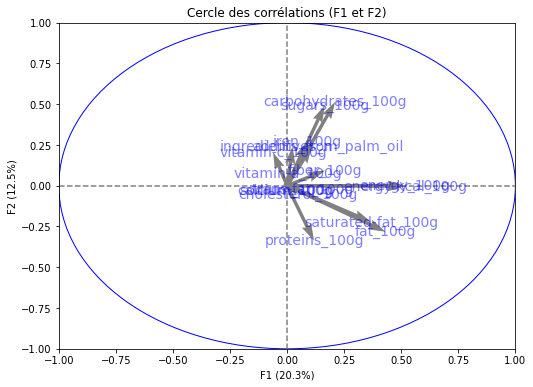

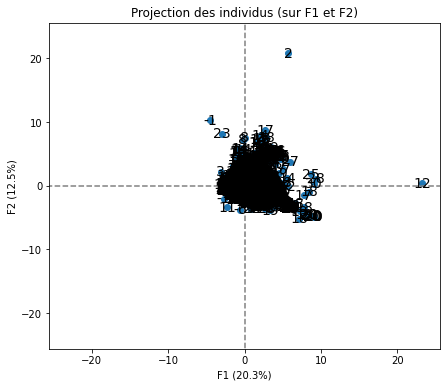

In [8]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 2, pca, [(0,1)], labels = np.array(scores))
plt.show()

In [9]:
# pcs = pd.DataFrame(pcs, index = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)],
#              columns=X.columns)
# X_projected = pd.DataFrame(X_projected, index = X.index, columns = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)])

It is hard to distinguish the too close variables. I go back to my idea of a hierarchical clustering on variables to first gather the ones with same comportement. Same as before, I mostly adapt the code from [the corresponding OC course](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345241-tp-partitionnez-vos-donnees).

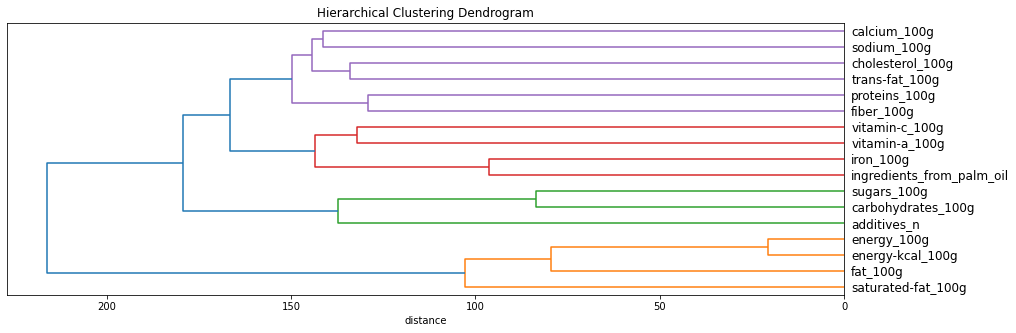

In [10]:
from scipy.cluster.hierarchy import linkage, fcluster

# Clustering hiérarchique
Z = linkage(X_scaled.transpose(), 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, X.columns, figsize = (15,5))

I modified the function to draw pca corr circle, so that I can put some clustering colors on the arrows, and print the corresponding legend : 

In [29]:
def get_str_vars(list_of_var):
    # from a list of str, return a sentence
    # if the line is too long (sup to 40), cut
    tmp = list_of_var.copy()
    res = ""
    len_line = 0
    while tmp : 
        var = tmp.pop()
        res = res+ var +str(", ")
        len_line += len(var)
        if len_line > 40:
            res = res +"\n"
            len_line = 0
    return(res)

def draw_cluster_legend(ax2,cluster, my_color_set):
    ## plot the legend with colored arrow
    # number of clusters : 
    K = max(cluster)+1
    # plot parallel arrows :
    ax2.quiver(np.zeros(K),np.arange(0,K),np.ones(K),np.zeros(K),
               color = my_color_set[:K])
    # plot legend text next to the respective arrow :
    for k in range(K):
        cluster_var = get_str_vars(list(cluster[cluster == k].index.values))
        ax2.text(0.2, k , str(cluster_var), fontsize='11',
                 ha='left', va='center' , alpha=1)
    # set limits : 
    ax2.set_xlim([-0.1,2])
    ax2.set_ylim([-1.1, K+0.1])
    ax2.set_title("Clustering legend")
    # remove axis :
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    plt.axis("off")
    return(ax2)
# fig2, ax2 = plt.subplots(1,1)
# draw_cluster_legend(ax2, cluster)
# plt.show()

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, cluster = None):
    ## draw the correlation circle for pca : 
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            fig = plt.figure(figsize = (18,6))
            # initialisation de la figure
            ax1 = fig.add_subplot(1,2,1)

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # gestion de la couleur si cluster : 
            if cluster is not None : 
                my_color_set = ['#c0022f', '#ff073a', '#f97306', '#fdaa48', 
                        '#fffd01', '#fea993', '#fe7b7c', '#ff81c0', '#fe02a2', 
                        '#c20078', '#c79fef', '#7e1e9c', '#380282', '#0343df', 
                        '#75bbfd', '#6b8ba4', '#029386', '#017371', '#15b01a', 
                        '#677a04', '#b25f03', '#8b3103', '#070d0d', '#c5c9c7']
                my_color = [my_color_set[i] for i in cluster.values]
            else : 
                my_color = "grey"


            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                ax1.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', 
                           scale=1, color=my_color)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax1.add_collection(LineCollection(lines, axes=ax, alpha=.1, color=my_color))

            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax1.text(x, y, labels[i], fontsize='14', ha='center', 
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            ax1.set_xlim(xmin, xmax)
            ax1.set_ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax1.set_xlabel('F{} ({}%)'.format(d1+1, 
                                round(100*pca.explained_variance_ratio_[d1],1)))
            ax1.set_ylabel('F{} ({}%)'.format(d2+1, 
                                round(100*pca.explained_variance_ratio_[d2],1)))
            ax1.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))

            ## affichage de la legende du clustering en couleur : 
            if cluster is not None : 
                ax2 = fig.add_subplot(1,2,2)
                draw_cluster_legend(ax2, cluster, my_color_set)
    plt.show(block=False)

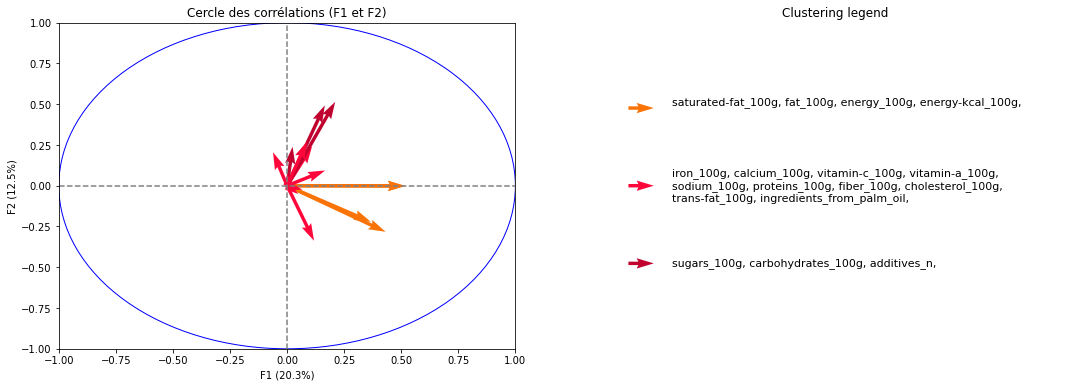

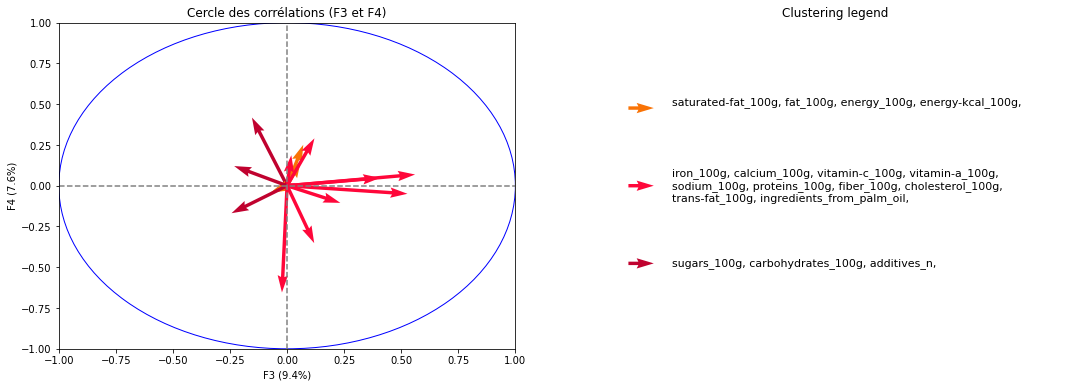

In [36]:
from scipy.cluster.hierarchy import cut_tree
import matplotlib._color_data as mcd
import random

clustering = pd.Series(cut_tree(Z, height=170).T[0], index=X.columns)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 4, pca, [(0,1), (2,3)], labels = None, cluster=clustering)


I've spent some time to define my own color palette, because each time it is a brainteaser :) 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
cluster3 = pd.Series(cut_tree(Z, height=150).T[0], index=X.columns)
my_color_set = random.sample(list(mcd.CSS4_COLORS.keys()), max(cluster3)+1)

my_color = [my_color_set[i] for i in cluster3.values]
my_color
## pb -> some colors are really too close or to bright, we can't see anything

colors = {"lipstick red":"#c0022f","neon red":"#ff073a", "orange":"#f97306", # rouge-orange 
          "goldenrod":"#fdaa48", "bright yellow": "#fffd01","light salmon":"#fea993", #jaune 
          "salmon pink":"#fe7b7c","pink":"#ff81c0","shocking pink":"#fe02a2","magenta":"#c20078", #rose 
          "lavender":"#c79fef", "purple":"#7e1e9c", "indigo":"#380282",# violet
          "blue":"#0343df","sky blue ":"#75bbfd", "grey blue" :"#6b8ba4", "teal":"#029386", # bleu
          "dark aquamarine":"#017371","green":"#15b01a","olive green": "#677a04", #vert
          "orangish brown":"#b25f03","rust brown":"#8b3103", #marron
          "almost black":"#070d0d",  "silver" : "#c5c9c7"#gris et noir
         }

def print_palette(colors, ncols = 4) :
    sorted_names = colors.keys()
    n = len(sorted_names)
    nrows = n // ncols 

    fig, ax = plt.subplots(figsize=(200, 30))
    # Get global height and width
    X, Y = fig.get_dpi() * fig.get_size_inches()
    h = Y / (nrows + 1)
    w = X / ncols

    for i, name in enumerate(sorted_names):
        row = i % nrows
        col = i // nrows
        # set local larger and longueur : 
        y = Y - (row * h) - h
        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)
        # plot and legend :
        ax.text(xi_text, y, name, fontsize=(h * 0.9),
                horizontalalignment='left',
                verticalalignment='center')
        ax.hlines(y + h * 0.1, xi_line, xf_line,
                  color=colors[name], linewidth=(h * 0.9))
    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1,top=1, bottom=0,
                        hspace=0, wspace=0)
    plt.show()
    
print_palette(colors)
## to get a random subset : 
# l = list(colors.items())
# random.shuffle(l)
# my_palette = dict(l)
# print_palette(my_palette)
colors.values()

In [ ]:
sorted_names = colors.keys()
ncols = 4
n = len(sorted_names)
nrows = n // ncols 
nrows

And this is random : I saw that I can download my electricity consumption on EDF website, I wanted to explore that

In [ ]:
tmp = pd.read_csv("/home/clairegayral/Téléchargements/mes-releves-elec.csv", sep = ";" , header = 1,encoding="ISO-8859-1")
tmp.dropna(axis = 0, inplace = True)
tmp.plot();

In [ ]:
nrows